## Importations

In [ ]:
!pip install -r /content/drive/MyDrive/EA-age/Project/requirements.txt

In [ ]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from imgaug import augmenters as iaa
import os
from transformers import ConvNextForImageClassification
import torchvision
import torch
import csv
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import pretrainedmodels
import pretrainedmodels.utils
from collections import OrderedDict
from tqdm import tqdm
from pathlib import Path

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp -R /content/drive/MyDrive/EA-age/Project/ressource/se_resnext50_32x4d-a260b3a4.pth /root/.cache/torch/hub/checkpoints/
#if model isn't downloaded, download it

In [ ]:
#!cp -R /content/drive/MyDrive/EA-age/Project/ressource/meta.py /usr/local/lib/python3.10/dist-packages/imgaug/augmenters/
#copy the meta.py file to the imgaug library to fix the error

In [ ]:
#!cp -R /content/drive/MyDrive/EA-age/Project/ressource/pnasnet.py /usr/local/lib/python3.10/dist-packages/pretrainedmodels/models/
#!cp -R /content/drive/MyDrive/EA-age/Project/ressource/pnasnet5large-bf079911.pth /root/.cache/torch/hub/checkpoints/
#copy the pnasnet.py file to the pretrainedmodels library to fix the error
#copy the pnasnet5large-bf079911.pth file to the pretrainedmodels library to fix the error

## Model.py, Train.py and Dataset.py

In [ ]:

class AverageMeter(object):
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    loss_monitor = AverageMeter()
    accuracy_monitor = AverageMeter()

    with tqdm(train_loader) as _tqdm:
        for x, y in _tqdm:
            x = x.to(device)
            y = y.type(torch.LongTensor) ### added
            y = y.to(device)

            # compute output
            outputs = model(x)

            # calc loss
            loss = criterion(outputs, y)
            cur_loss = loss.item()

            # calc accuracy
            _, predicted = outputs.max(1)
            correct_num = predicted.eq(y).sum().item()

            # measure accuracy and record loss
            sample_num = x.size(0)
            loss_monitor.update(cur_loss, sample_num)
            accuracy_monitor.update(correct_num, sample_num)

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _tqdm.set_postfix(OrderedDict(stage="train", epoch=epoch, loss=loss_monitor.avg),
                              acc=accuracy_monitor.avg, correct=correct_num, sample_num=sample_num)

    return loss_monitor.avg, accuracy_monitor.avg

def validate(validate_loader, model, criterion, epoch, device):
    model.eval()
    loss_monitor = AverageMeter()
    accuracy_monitor = AverageMeter()
    preds = []
    gt = []

    with torch.no_grad():
        with tqdm(validate_loader) as _tqdm:
            for x, y in _tqdm:
                x = x.to(device)
                y = y.type(torch.LongTensor) ### added
                y = y.to(device)

                # compute output
                outputs = model(x)
                preds.append(F.softmax(outputs, dim=-1).cpu().numpy())
                gt.append(y.cpu().numpy())

                # valid for validation, not used for test
                if criterion is not None:
                    # calc loss
                    loss = criterion(outputs, y)
                    cur_loss = loss.item()

                    # calc accuracy
                    _, predicted = outputs.max(1)
                    correct_num = predicted.eq(y).sum().item()

                    # measure accuracy and record loss
                    sample_num = x.size(0)
                    loss_monitor.update(cur_loss, sample_num)
                    accuracy_monitor.update(correct_num, sample_num)
                    _tqdm.set_postfix(OrderedDict(stage="val", epoch=epoch, loss=loss_monitor.avg),
                                      acc=accuracy_monitor.avg, correct=correct_num, sample_num=sample_num)

    preds = np.concatenate(preds, axis=0)
    gt = np.concatenate(gt, axis=0)
    ages = np.arange(0, 101)
    ave_preds = (preds * ages).sum(axis=-1)
    diff = ave_preds - gt
    mae = np.abs(diff).mean()

    return loss_monitor.avg, accuracy_monitor.avg, mae

def train_reg(train_loader, model, criterion, optimizer, epoch, device):
    '''loss recommandée : nn.MSELoss()'''
    model.train()
    loss_monitor = AverageMeter()
    accuracy_monitor = AverageMeter()

    with tqdm(train_loader) as _tqdm:
        for x, y in _tqdm:
            x = x.to(device)
            y = y.type(torch.FloatTensor) ###modified ### added
            y = y.to(device)

            # compute output
            outputs = model(x)
            predicted = outputs.squeeze(1)

            # calc loss
            loss = criterion(predicted, y)
            cur_loss = loss.item()

            # calc accuracy
            #_, predicted = outputs.max(1)
            #predicted = outputs.squeeze(1) ### modified# Assuming outputs is a tensor of shape (batch_size, 1)
            #correct_num = y.eq(torch.round(y + 0.49)).sum().item() ###modified
            correct_num = torch.abs(predicted - y).le(1).sum().item()

            #correct_num = np.mean(np.round(outputs.cpu().numpy() + 0.49) == y.cpu().numpy())


            # measure accuracy and record loss
            sample_num = x.size(0)
            loss_monitor.update(cur_loss, sample_num)
            accuracy_monitor.update(correct_num, sample_num)

            #mae = torch.abs(outputs - y).mean()  ### modified # Assuming outputs and y are tensors of the same shape
            #accuracy_monitor.update(mae.item(), sample_num)


            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _tqdm.set_postfix(OrderedDict(stage="train", epoch=epoch, loss=loss_monitor.avg),
                             acc=accuracy_monitor.avg, correct=correct_num, sample_num=sample_num)
            #_tqdm.set_postfix(OrderedDict(stage="train", epoch=epoch, loss=loss_monitor.avg),
            #                  acc=accuracy_monitor.avg, sample_num=sample_num)

    return loss_monitor.avg, accuracy_monitor.avg

def validate_reg(validate_loader, model, criterion, epoch, device):
    model.eval()
    loss_monitor = AverageMeter()
    accuracy_monitor = AverageMeter()
    preds = []
    gt = []

    with torch.no_grad():
        with tqdm(validate_loader) as _tqdm:
            for x, y in _tqdm:
                x = x.to(device)
                y = y.type(torch.FloatTensor) ### added
                y = y.to(device)

                # compute output
                outputs = model(x)
                #preds.append(F.softmax(outputs, dim=-1).cpu().numpy())
                preds.append(outputs.cpu().numpy())
                gt.append(y.cpu().numpy())

                # valid for validation, not used for test
                if criterion is not None:
                    # calc loss
                    predicted = outputs.squeeze(1)
                    loss = criterion(predicted, y)
                    cur_loss = loss.item()

                    # calc accuracy
                    #_, predicted = outputs.max(1)
                    #predicted = outputs.squeeze(1) ###modified
                    #correct_num = np.sum(np.round(outputs.cpu().numpy() + 0.49) == y.cpu().numpy()) ###modified
                    #correct_num = np.sum(np.abs(outputs.cpu().numpy() - y.cpu().numpy()) <= 1) ###modified
                    correct_num = torch.abs(predicted - y).le(1).sum().item()


                    # measure accuracy and record loss
                    sample_num = x.size(0)
                    #loss_monitor.update(cur_loss, sample_num)
                    loss_monitor.update(loss.item(),sample_num)
                    accuracy_monitor.update(correct_num, sample_num)
                    #mae = torch.abs(outputs - y).mean()  ### modified # Assuming outputs and y are tensors of the same shape
                    #accuracy_monitor.update(mae.item(), sample_num)
                    _tqdm.set_postfix(OrderedDict(stage="val", epoch=epoch, loss=loss_monitor.avg),
                                      acc=accuracy_monitor.avg, correct=correct_num, sample_num=sample_num)
                    #_tqdm.set_postfix(OrderedDict(stage="val", epoch=epoch, loss=loss_monitor.avg),
                    #                    acc=accuracy_monitor.avg, sample_num=sample_num)


    #preds = np.concatenate(preds, axis=0)
    #gt = np.concatenate(gt, axis=0)
    #ages = np.arange(0, 101)
    #ave_preds = (preds * ages).sum(axis=-1)
    #diff = ave_preds - gt
    #mae = np.abs(diff).mean()
    preds = np.concatenate(preds, axis=0)
    gt = np.concatenate(gt, axis=0)
    mae = np.mean(np.abs(preds - gt))

    return loss_monitor.avg, accuracy_monitor.avg, mae

In [ ]:
def get_model(model_name="se_resnext50_32x4d", num_classes=101, pretrained="imagenet"):
    model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
    dim_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(dim_feats, num_classes)
    model.avg_pool = nn.AdaptiveAvgPool2d(1)
    return model

def get_regression_model(model_name="se_resnext50_32x4d", pretrained="imagenet"):
    model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
    dim_feats = model.last_linear.in_features
    model.last_linear = nn.Linear(dim_feats, 1)  # Regression predicts a single value, so output dimension is 1
    # Optionally other layers if needed
    return model

In [ ]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.OneOf([
                iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(scale=0.1 * 255)),
                iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0)))
                ]),
            iaa.Affine(
                rotate=(-20, 20), mode="edge",
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
            ),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
            iaa.GammaContrast((0.3, 2)),
            iaa.Fliplr(0.5),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img

def identity(x): ### added
    return x

class FaceDataset(Dataset):
    def __init__(self, data_dir, data_type, img_size=224, augment=False, age_stddev=1.0, ignore_path = '/content/drive/MyDrive/EA-age/Project/ignore_list.csv'):
        assert(data_type in ("train", "valid", "test"))
        csv_path = Path(data_dir).joinpath(f"gt_avg_{data_type}.csv")
        img_dir = Path(data_dir).joinpath(data_type)
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev

        if augment:
            self.transform = ImgAugTransform()
        else:
            self.transform = identity ### added

        self.x = []
        self.y = []
        self.std = []
        df = pd.read_csv(str(csv_path))
        #ignore_path = Path(__file__).resolve().parent.joinpath(ignore_path)
        ignore_img_names = list(pd.read_csv(str(ignore_path))["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]

            if img_name in ignore_img_names:
                continue

            img_path = img_dir.joinpath(img_name + "_face.jpg")
            assert(img_path.is_file())
            self.x.append(str(img_path))
            self.y.append(row["apparent_age_avg"])
            self.std.append(row["apparent_age_std"])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn() * self.std[idx] * self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

## Utils

In [ ]:
def add_ignore(path, new_path, n_values):
  df = pd.read_csv(path)
  val = list(df['img_name'].values)
  for i in range(n_values):
    num = str(i)
    x = 6-len(num)
    complete = '0'*x
    val.append(complete+num+'.jpg')
  df2 = pd.DataFrame({"img_name": val})
  df2.to_csv(new_path, index=False)

In [ ]:
def show(image):
    if type(image) != str:
        tensor = np.array(image)
        tensor_min, tensor_max = np.min(tensor), np.max(tensor)
        tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
        tensor = np.transpose(tensor, (1, 2, 0))
        plt.axis(False)
        plt.imshow(tensor)
    else :
        img = cv2.imread(image, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

In [ ]:
def load_model(model,optimizer, path, device):
    print("=> loading checkpoint '{}'".format(path))
    checkpoint = torch.load(path, map_location=device)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> loaded checkpoint '{}' (epoch {})"
                  .format(path, checkpoint['epoch']))
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
def training(model,optimizer, train_loader, val_loader, test_loader, epochs, save_path,csv_path, device):
    best_val_mae = 10000.0
    criterion = nn.CrossEntropyLoss().to(device)

    tr_loss, tr_acc, v_loss, v_acc, mae = [],[],[],[],[]
    #print(tr.validate(val_loader, model, criterion, 0, device))
    #print(tr.validate(test_loader, model, criterion, 0, device))
    for epoch in range(0, epochs):
            # train
            train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, device)

            # validate
            val_loss, val_acc, val_mae = validate(val_loader, model, criterion, epoch, device)
            tr_acc.append(train_acc)
            tr_loss.append(train_loss)
            v_loss.append(val_loss)
            v_acc.append(val_acc)
            mae.append(val_mae)

            if val_mae < best_val_mae:
                    print(f"=> [epoch {epoch:03d}] best val mae was improved from {best_val_mae:.3f} to {val_mae:.3f}")
                    model_state_dict = model.state_dict()
                    model_path = save_path + "epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, val_loss, val_mae)
                    torch.save(
                        {
                            'epoch': epoch + 1,
                            'state_dict': model_state_dict,
                            'optimizer_state_dict': optimizer.state_dict()
                        },
                        model_path
                    )
                    best_val_mae = val_mae

    load_model(model, optimizer,model_path,device)
    test_loss, test_acc, test_mae = validate(test_loader, model, criterion, 0, device)
    print(test_loss, test_acc, test_mae)

    df2 = pd.DataFrame({"train_acc": tr_acc, "train_loss": tr_loss, "val_loss": v_loss, "val_acc": v_acc, "mae": mae})
    df2.to_csv(csv_path, index=False)

    return tr_loss, tr_acc, v_loss, v_acc, mae, [test_loss, test_acc, test_mae]

In [ ]:
def training_reg(model,optimizer, train_loader, val_loader, test_loader, epochs, save_path,csv_path, device):
    best_val_mae = 10000.0
    criterion = nn.MSELoss().to(device)

    tr_loss, tr_acc, v_loss, v_acc, mae = [],[],[],[],[]
    #print(tr.validate(val_loader, model, criterion, 0, device))
    #print(tr.validate(test_loader, model, criterion, 0, device))
    for epoch in range(0, epochs):
            # train
            train_loss, train_acc = train_reg(train_loader, model, criterion, optimizer, epoch, device)

            # validate
            val_loss, val_acc, val_mae = validate_reg(val_loader, model, criterion, epoch, device)
            tr_acc.append(train_acc)
            tr_loss.append(train_loss)
            v_loss.append(val_loss)
            v_acc.append(val_acc)
            mae.append(val_mae)

            if val_mae < best_val_mae:
                    print(f"=> [epoch {epoch:03d}] best val mae was improved from {best_val_mae:.3f} to {val_mae:.3f}")
                    model_state_dict = model.state_dict()
                    model_path = save_path + "epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, val_loss, val_mae)
                    torch.save(
                        {
                            'epoch': epoch + 1,
                            'state_dict': model_state_dict,
                            'optimizer_state_dict': optimizer.state_dict()
                        },
                        model_path
                    )
                    best_val_mae = val_mae

    load_model(model, optimizer,model_path,device)
    test_loss, test_acc, test_mae = validate_reg(test_loader, model, criterion, 0, device)
    print(test_loss, test_acc, test_mae)

    df2 = pd.DataFrame({"train_acc": tr_acc, "train_loss": tr_loss, "val_loss": v_loss, "val_acc": v_acc, "mae": mae})
    df2.to_csv(csv_path, index=False)

    return tr_loss, tr_acc, v_loss, v_acc, mae, [test_loss, test_acc, test_mae]

In [ ]:
add_ignore('/content/drive/MyDrive/EA-age/Project/ignore_list.csv', '/content/drive/MyDrive/EA-age/Project/ignore_list1000.csv', 4000 - 1000)

## Dataset utils for augmented datasets

In [ ]:
class FaceDataset_synthetic_unlabelled(Dataset):
    def __init__(self, data_dir, img_size=224):
        self.img_size = img_size
        self.transform = lambda i:i
        self.x = []
        for img in os.listdir(data_dir):
            self.x.append(data_dir + '/' + img)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1)))

class FaceDataset_synthetic_labelled(Dataset):
    def __init__(self, data_dir, csv_path, img_size=224,augment=False, age_stddev=1.0):
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i

        self.x = []
        self.y = []
        df = pd.read_csv(csv_path)

        for _, row in df.iterrows():
            img_name = row["img_name"]
            img_path = data_dir + '/' + img_name
            self.x.append(img_path)
            self.y.append(row["predicted_age"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

In [ ]:
class FaceDataset_mix_syn_real(Dataset):
    def __init__(self, data_dirs, csv_paths, n = 1000, img_size=224,augment=False, age_stddev=1.0):
        data_dir, data_dir_synthetic = data_dirs[0], data_dirs[1]
        csv_path, csv_path_synthetic = csv_paths[0], csv_paths[1]

        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i

        self.x = []
        self.x2 = []
        self.y = []
        self.y2 = []
        df = pd.read_csv(csv_path)
        ignore_img_names = list(pd.read_csv("ignore_list.csv")["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]
            if img_name in ignore_img_names:
                continue

            img_path = data_dir + '/train/' + img_name
            self.x.append(img_path)
            self.y.append(row["apparent_age_avg"])

        df2 = pd.read_csv(csv_path_synthetic)
        for _, row in df.iterrows():
            img_name = row["img_name"]
            img_path = data_dir + '/' + img_name
            self.x2.append(img_path)
            self.y2.append(row["predicted_age"])

        self.x2 = self.x2[0:n//2]
        self.x = self.x[0:n//2] + self.x2
        self.y2 = self.y2[0:n//2]
        self.y = self.y[0:n//2] + self.y2

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.age_stddev

        img = cv2.imread(str(img_path), 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

In [ ]:
class FaceDataset_gender(Dataset):
    def __init__(self, data_dir, csv_path, gender, img_size=224,augment=False, age_stddev=1.0):
        self.img_size = img_size
        self.augment = augment
        self.age_stddev = age_stddev
        assert(gender in ("male", "female"))
        if augment:
            self.transform = dataset.ImgAugTransform()
        else:
            self.transform = lambda i:i

        self.x = []
        self.y = []
        self.std = []
        df = pd.read_csv(csv_path)
        ignore_img_names = list(pd.read_csv("ignore_list.csv")["img_name"].values)

        for _, row in df.iterrows():
            img_name = row["file_name"]
            if img_name in ignore_img_names:
                continue

            img_path = data_dir + '/train/' + img_name
            if row["gender"] == gender:
                self.x.append(img_path)
                self.y.append(row["apparent_age_avg"])
                self.std.append(row["apparent_age_std"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path = self.x[idx]
        age = self.y[idx]

        if self.augment:
            age += np.random.randn()* self.std[idx]* self.age_stddev

        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = self.transform(img).astype(np.float32)
        return torch.from_numpy(np.transpose(img, (2, 0, 1))), np.clip(round(age), 0, 100)

# Pipelines

## Basic

In [ ]:
torch.cuda.empty_cache()

In [ ]:
path = '/content/drive/MyDrive/EA-age/Project/'

data_dir = path + 'appa-real-release'
data_type = 'train'
train_dataset = FaceDataset(data_dir, data_type, ignore_path = path + 'ignore_list1000.csv', augment = True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = FaceDataset(data_dir, 'valid')
test_dataset = FaceDataset(data_dir, 'test')
val_dataset.x = val_dataset.x[:500]
val_dataset.y = val_dataset.y[:500]
test_dataset.x = test_dataset.x[:500]
test_dataset.y = test_dataset.y[:500]
#val_dataset.x = val_dataset.x
#val_dataset.y = val_dataset.y
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
print(len(train_dataset))

1086


### Regression model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = get_regression_model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss_r, tr_acc_r, v_loss_r, v_acc_r, mae_r, test_metrics_r = training_reg(model, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/res_reg',path + 'values_training_reg.csv', device)
test_loss_r, test_acc_r, test_mae_r = test_metrics_r[0], test_metrics_r[1], test_metrics_r[2]

100%|██████████| 16/16 [00:06<00:00,  2.36it/s, stage=val, epoch=0, loss=7.06, acc=0.066, correct=2, sample_num=20]


=> [epoch 000] best val mae was improved from 10000.000 to 16.090


100%|██████████| 16/16 [00:07<00:00,  2.25it/s, stage=val, epoch=1, loss=5.78, acc=0.072, correct=3, sample_num=20]


=> [epoch 001] best val mae was improved from 16.090 to 13.972


100%|██████████| 16/16 [00:06<00:00,  2.36it/s, stage=val, epoch=2, loss=4.99, acc=0.088, correct=2, sample_num=20]


=> [epoch 002] best val mae was improved from 13.972 to 13.686


100%|██████████| 16/16 [00:07<00:00,  2.25it/s, stage=val, epoch=59, loss=3.4, acc=0.088, correct=0, sample_num=20]


=> loading checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/res_regepoch002_4.99088_13.6860.pth'
=> loaded checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/res_regepoch002_4.99088_13.6860.pth' (epoch 3)


100%|██████████| 16/16 [07:11<00:00, 26.97s/it, stage=val, epoch=0, loss=6.3, acc=0.076, correct=0, sample_num=20]

6.302915786743164 0.076 14.522778


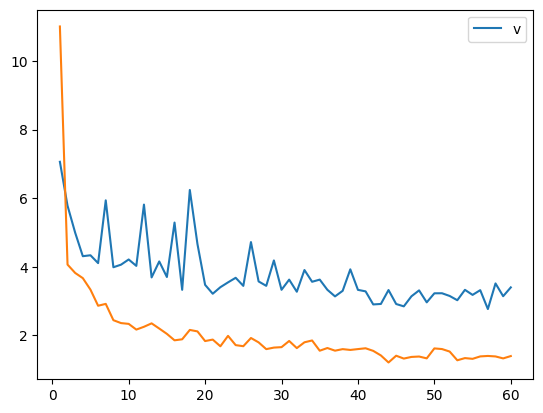

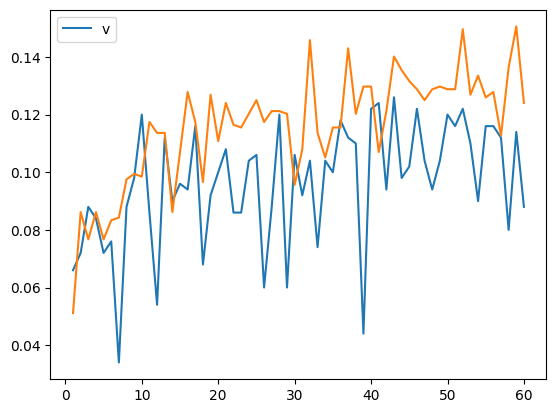

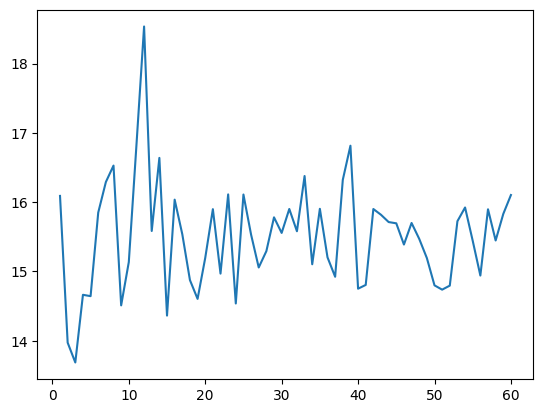

In [ ]:
epochs = np.arange(1,61)
plt.plot(epochs, v_loss_r, label = 'v')
plt.plot(epochs, tr_loss_r)
plt.legend()
plt.show()
plt.plot(epochs, v_acc_r, label='v')
plt.plot(epochs, tr_acc_r)
plt.legend()
plt.show()
plt.plot(epochs, mae_r)
plt.show()


### Classification model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_c = get_model()
model_c = model_c.to(device)
optimizer = torch.optim.Adam(model_c.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model_c, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/res_1000_base_',path + 'values_training_1000bas.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

100%|██████████| 16/16 [03:20<00:00, 12.55s/it, stage=val, epoch=0, loss=0.165, acc=0.042, correct=1, sample_num=20]


=> [epoch 000] best val mae was improved from 10000.000 to 12.232


100%|██████████| 16/16 [00:04<00:00,  3.43it/s, stage=val, epoch=1, loss=0.139, acc=0.046, correct=0, sample_num=20]


=> [epoch 001] best val mae was improved from 12.232 to 12.011


100%|██████████| 16/16 [00:04<00:00,  3.47it/s, stage=val, epoch=2, loss=0.133, acc=0.044, correct=3, sample_num=20]


=> [epoch 002] best val mae was improved from 12.011 to 11.571


100%|██████████| 16/16 [00:04<00:00,  3.59it/s, stage=val, epoch=5, loss=0.129, acc=0.05, correct=1, sample_num=20]


=> [epoch 005] best val mae was improved from 11.571 to 11.352


100%|██████████| 16/16 [00:04<00:00,  3.43it/s, stage=val, epoch=7, loss=0.132, acc=0.038, correct=1, sample_num=20]


=> [epoch 007] best val mae was improved from 11.352 to 11.027


100%|██████████| 16/16 [00:04<00:00,  3.44it/s, stage=val, epoch=10, loss=0.124, acc=0.06, correct=2, sample_num=20]


=> [epoch 010] best val mae was improved from 11.027 to 10.519


100%|██████████| 16/16 [00:04<00:00,  3.45it/s, stage=val, epoch=13, loss=0.125, acc=0.058, correct=1, sample_num=20]


=> [epoch 013] best val mae was improved from 10.519 to 10.131


100%|██████████| 16/16 [00:04<00:00,  3.49it/s, stage=val, epoch=14, loss=0.121, acc=0.05, correct=3, sample_num=20]


=> [epoch 014] best val mae was improved from 10.131 to 9.921


100%|██████████| 16/16 [00:04<00:00,  3.49it/s, stage=val, epoch=15, loss=0.124, acc=0.056, correct=2, sample_num=20]


=> [epoch 015] best val mae was improved from 9.921 to 9.672


100%|██████████| 16/16 [00:04<00:00,  3.43it/s, stage=val, epoch=16, loss=0.123, acc=0.058, correct=1, sample_num=20]


=> [epoch 016] best val mae was improved from 9.672 to 9.244


100%|██████████| 16/16 [00:04<00:00,  3.22it/s, stage=val, epoch=18, loss=0.127, acc=0.042, correct=1, sample_num=20]


=> [epoch 018] best val mae was improved from 9.244 to 8.970


100%|██████████| 16/16 [00:04<00:00,  3.48it/s, stage=val, epoch=19, loss=0.118, acc=0.052, correct=1, sample_num=20]


=> [epoch 019] best val mae was improved from 8.970 to 8.433


100%|██████████| 16/16 [00:04<00:00,  3.50it/s, stage=val, epoch=23, loss=0.118, acc=0.054, correct=0, sample_num=20]


=> [epoch 023] best val mae was improved from 8.433 to 8.307


100%|██████████| 16/16 [00:04<00:00,  3.31it/s, stage=val, epoch=24, loss=0.116, acc=0.052, correct=3, sample_num=20]


=> [epoch 024] best val mae was improved from 8.307 to 8.054


100%|██████████| 16/16 [00:04<00:00,  3.24it/s, stage=val, epoch=26, loss=0.117, acc=0.06, correct=3, sample_num=20]


=> [epoch 026] best val mae was improved from 8.054 to 7.878


100%|██████████| 16/16 [00:04<00:00,  3.32it/s, stage=val, epoch=28, loss=0.115, acc=0.072, correct=3, sample_num=20]


=> [epoch 028] best val mae was improved from 7.878 to 7.828


100%|██████████| 16/16 [00:04<00:00,  3.42it/s, stage=val, epoch=29, loss=0.116, acc=0.044, correct=1, sample_num=20]


=> [epoch 029] best val mae was improved from 7.828 to 7.755


100%|██████████| 16/16 [00:04<00:00,  3.46it/s, stage=val, epoch=38, loss=0.113, acc=0.082, correct=3, sample_num=20]


=> [epoch 038] best val mae was improved from 7.755 to 7.436


100%|██████████| 16/16 [00:04<00:00,  3.52it/s, stage=val, epoch=42, loss=0.114, acc=0.068, correct=2, sample_num=20]


=> [epoch 042] best val mae was improved from 7.436 to 7.355


100%|██████████| 16/16 [00:04<00:00,  3.37it/s, stage=val, epoch=56, loss=0.114, acc=0.066, correct=3, sample_num=20]


=> [epoch 056] best val mae was improved from 7.355 to 7.335


100%|██████████| 16/16 [00:04<00:00,  3.55it/s, stage=val, epoch=59, loss=0.114, acc=0.088, correct=0, sample_num=20]


=> [epoch 059] best val mae was improved from 7.335 to 7.230
=> loading checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/res_1000_base_epoch059_0.11392_7.2295.pth'
=> loaded checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/res_1000_base_epoch059_0.11392_7.2295.pth' (epoch 60)


100%|██████████| 16/16 [03:22<00:00, 12.68s/it, stage=val, epoch=0, loss=0.12, acc=0.062, correct=0, sample_num=20]

0.11981658172607422 0.062 7.633030133447444


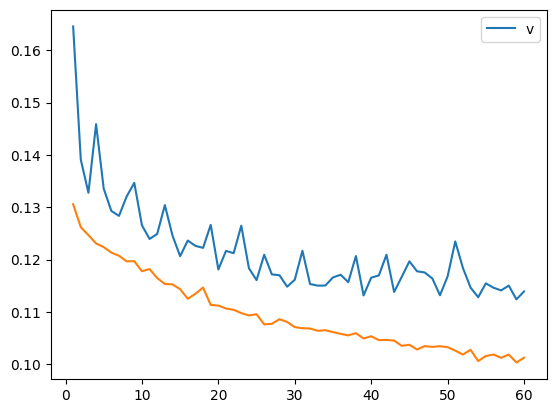

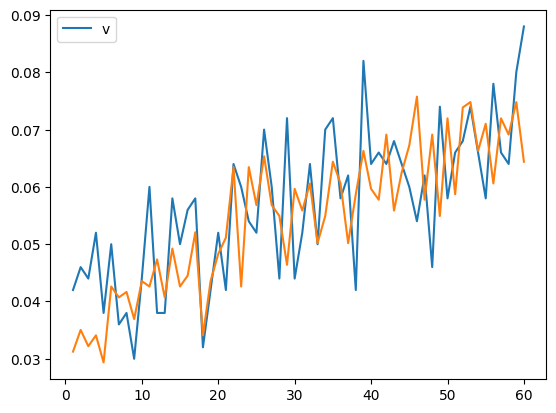

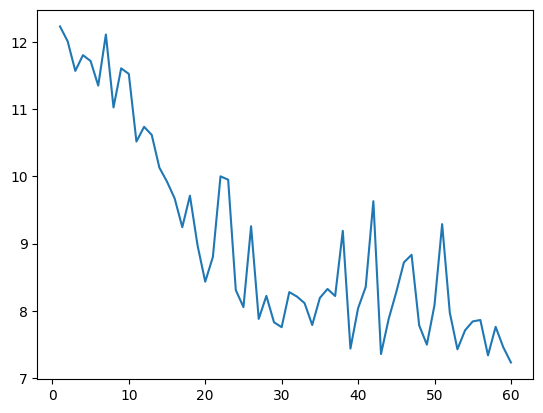

In [ ]:
epochs = np.arange(1,61)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()


### Other models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_c = get_model('vgg16')
model_c = model_c.to(device)
optimizer = torch.optim.Adam(model_c.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model_c, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/vgg2_1000_base_',path + 'values_training_1000vgg2.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

100%|██████████| 32/32 [00:05<00:00,  6.35it/s, stage=val, epoch=0, loss=0.274, acc=0.022, correct=0, sample_num=4]


=> [epoch 000] best val mae was improved from 10000.000 to 12.926


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_c = get_model('pnasnet5large')
model_c = model_c.to(device)
optimizer = torch.optim.Adam(model_c.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model_c, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/pna_1000_base_',path + 'values_training_1000pna.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

100%|██████████| 32/32 [00:06<00:00,  4.90it/s, stage=val, epoch=0, loss=3.24, acc=0.02, correct=0, sample_num=4]


=> [epoch 000] best val mae was improved from 10000.000 to 12.738


100%|██████████| 32/32 [00:06<00:00,  5.12it/s, stage=val, epoch=1, loss=0.285, acc=0.034, correct=0, sample_num=4]


=> [epoch 001] best val mae was improved from 12.738 to 12.478


100%|██████████| 32/32 [00:06<00:00,  5.12it/s, stage=val, epoch=2, loss=0.276, acc=0.016, correct=0, sample_num=4]


=> [epoch 002] best val mae was improved from 12.478 to 12.377


100%|██████████| 32/32 [00:06<00:00,  5.20it/s, stage=val, epoch=12, loss=0.269, acc=0.02, correct=0, sample_num=4]


=> [epoch 012] best val mae was improved from 12.377 to 12.331


100%|██████████| 32/32 [00:06<00:00,  5.24it/s, stage=val, epoch=16, loss=0.27, acc=0.038, correct=0, sample_num=4]


=> [epoch 016] best val mae was improved from 12.331 to 12.253


100%|██████████| 32/32 [00:06<00:00,  5.10it/s, stage=val, epoch=18, loss=0.275, acc=0.028, correct=0, sample_num=4]


=> [epoch 018] best val mae was improved from 12.253 to 12.177


100%|██████████| 32/32 [00:06<00:00,  5.12it/s, stage=val, epoch=23, loss=0.28, acc=0.044, correct=0, sample_num=4]


=> [epoch 023] best val mae was improved from 12.177 to 12.165


100%|██████████| 32/32 [00:06<00:00,  5.03it/s, stage=val, epoch=48, loss=0.264, acc=0.04, correct=1, sample_num=4]


=> [epoch 048] best val mae was improved from 12.165 to 12.109


100%|██████████| 32/32 [00:06<00:00,  5.04it/s, stage=val, epoch=50, loss=0.261, acc=0.036, correct=0, sample_num=4]


=> [epoch 050] best val mae was improved from 12.109 to 12.036


100%|██████████| 32/32 [00:06<00:00,  4.97it/s, stage=val, epoch=55, loss=0.255, acc=0.032, correct=1, sample_num=4]


=> [epoch 055] best val mae was improved from 12.036 to 11.944


100%|██████████| 32/32 [00:06<00:00,  5.08it/s, stage=val, epoch=59, loss=0.266, acc=0.038, correct=0, sample_num=4]


=> [epoch 059] best val mae was improved from 11.944 to 11.841
=> loading checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/pna_1000_base_epoch059_0.26572_11.8410.pth'
=> loaded checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/pna_1000_base_epoch059_0.26572_11.8410.pth' (epoch 60)


100%|██████████| 32/32 [00:06<00:00,  4.74it/s, stage=val, epoch=0, loss=0.265, acc=0.054, correct=0, sample_num=4]

0.2651539826393127 0.054 11.17476644252578


In [ ]:
class ConvNextFinetune(nn.Module):
    """ Model using ConvNext as backbone with a linear classifier """
    def __init__(self, num_classes, frozen = False):
        super().__init__()

        self.backbone = ConvNextForImageClassification.from_pretrained("facebook/convnext-large-224")
        self.backbone.classifier = nn.Identity()
        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.classifier = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.backbone(x).logits
        x = self.classifier(x)
        return x


In [ ]:
#model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
#model = torchvision.models.vit_b_16("ViT_B_16_Weights.DEFAULT")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.vit_b_16("ViT_B_16_Weights.DEFAULT")

dim_feats = model.heads.head.in_features
model.heads.head = nn.Linear(dim_feats, 101)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/vit_1000_base_',path + 'values_training_1000vit.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
100%|██████████| 16/16 [00:05<00:00,  2.93it/s, stage=val, epoch=0, loss=0.138, acc=0.036, correct=0, sample_num=20]


=> [epoch 000] best val mae was improved from 10000.000 to 12.251


100%|██████████| 16/16 [00:05<00:00,  2.95it/s, stage=val, epoch=59, loss=0.132, acc=0.042, correct=2, sample_num=20]


=> loading checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/vit_1000_base_epoch000_0.13753_12.2506.pth'
=> loaded checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/vit_1000_base_epoch000_0.13753_12.2506.pth' (epoch 1)


100%|██████████| 16/16 [00:05<00:00,  2.80it/s, stage=val, epoch=0, loss=0.141, acc=0.03, correct=1, sample_num=20]

0.140567720413208 0.03 12.087922205541684


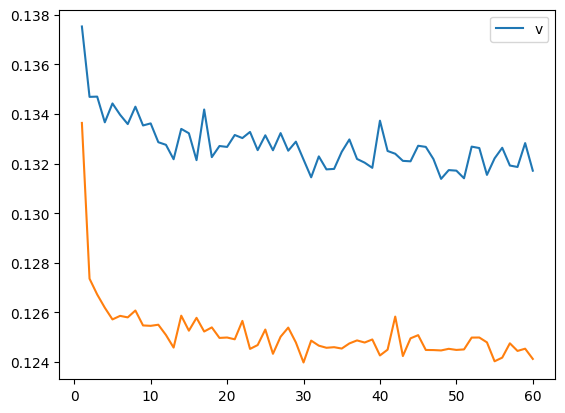

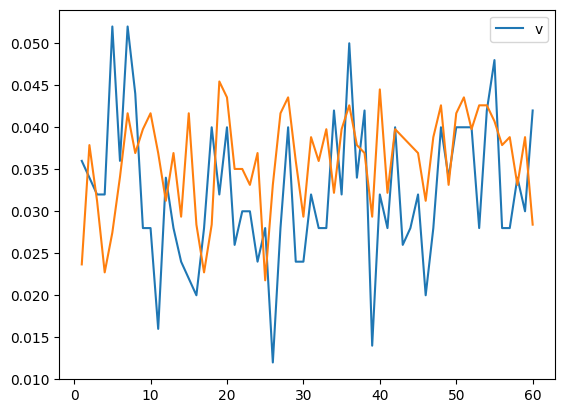

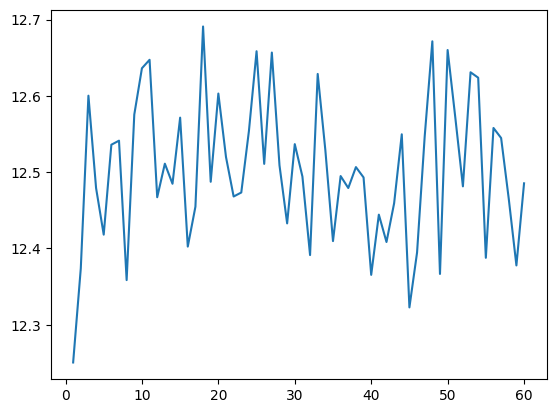

In [ ]:
epochs = np.arange(1,61)
plt.plot(epochs, v_loss, label = 'v')
plt.plot(epochs, tr_loss)
plt.legend()
plt.show()
plt.plot(epochs, v_acc, label='v')
plt.plot(epochs, tr_acc)
plt.legend()
plt.show()
plt.plot(epochs, mae)
plt.show()


In [ ]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
print(train_dataset[10][0].shape)

torch.Size([3, 224, 224])


In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Couche entièrement connectée avec 512 neurones
        self.relu = nn.ReLU()  # Fonction d'activation ReLU
        self.fc2 = nn.Linear(512, output_size)  # Couche entièrement connectée en sortie avec le nombre de classes en sortie

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir l'image en un vecteur (3x224x224 devient un vecteur de taille 3*224*224)
        x = self.fc1(x)  # Passer par la première couche entièrement connectée
        x = self.relu(x)  # Appliquer la fonction d'activation ReLU
        x = self.fc2(x)  # Passer par la deuxième couche entièrement connectée
        return x


In [ ]:
input_size = 3 * 224 * 224  # Taille de vos images en entrée
output_size = 101  # Nombre de classes en sortie
model = SimpleClassifier(input_size, output_size)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

tr_loss, tr_acc, v_loss, v_acc, mae, test_metrics = training(model, optimizer, train_loader, val_loader, test_loader, 60, path + 'train_models/slp_1000_base_',path + 'values_training_1000slp.csv', device)
test_loss, test_acc, test_mae = test_metrics[0], test_metrics[1], test_metrics[2]

100%|██████████| 16/16 [00:03<00:00,  4.12it/s, stage=val, epoch=0, loss=78.7, acc=0.032, correct=0, sample_num=20]


=> [epoch 000] best val mae was improved from 10000.000 to 18.249


100%|██████████| 16/16 [00:03<00:00,  4.10it/s, stage=val, epoch=22, loss=0.14, acc=0.028, correct=1, sample_num=20]


=> [epoch 022] best val mae was improved from 18.249 to 18.110


100%|██████████| 16/16 [00:04<00:00,  3.94it/s, stage=val, epoch=23, loss=0.139, acc=0.04, correct=3, sample_num=20]


=> [epoch 023] best val mae was improved from 18.110 to 17.959


100%|██████████| 16/16 [00:04<00:00,  3.97it/s, stage=val, epoch=24, loss=0.139, acc=0.04, correct=3, sample_num=20]


=> [epoch 024] best val mae was improved from 17.959 to 17.813


100%|██████████| 16/16 [00:03<00:00,  4.12it/s, stage=val, epoch=25, loss=0.139, acc=0.028, correct=1, sample_num=20]


=> [epoch 025] best val mae was improved from 17.813 to 17.677


100%|██████████| 16/16 [00:04<00:00,  3.83it/s, stage=val, epoch=26, loss=0.139, acc=0.028, correct=1, sample_num=20]


=> [epoch 026] best val mae was improved from 17.677 to 17.541


100%|██████████| 16/16 [00:04<00:00,  3.81it/s, stage=val, epoch=27, loss=0.138, acc=0.028, correct=1, sample_num=20]


=> [epoch 027] best val mae was improved from 17.541 to 17.406


100%|██████████| 16/16 [00:04<00:00,  3.83it/s, stage=val, epoch=28, loss=0.138, acc=0.028, correct=1, sample_num=20]


=> [epoch 028] best val mae was improved from 17.406 to 17.279


100%|██████████| 16/16 [00:03<00:00,  4.12it/s, stage=val, epoch=29, loss=0.138, acc=0.028, correct=1, sample_num=20]


=> [epoch 029] best val mae was improved from 17.279 to 17.151


100%|██████████| 16/16 [00:03<00:00,  4.21it/s, stage=val, epoch=30, loss=0.138, acc=0.028, correct=1, sample_num=20]


=> [epoch 030] best val mae was improved from 17.151 to 17.030


100%|██████████| 16/16 [00:03<00:00,  4.22it/s, stage=val, epoch=31, loss=0.137, acc=0.04, correct=3, sample_num=20]


=> [epoch 031] best val mae was improved from 17.030 to 16.911


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, stage=val, epoch=32, loss=0.137, acc=0.028, correct=1, sample_num=20]


=> [epoch 032] best val mae was improved from 16.911 to 16.793


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, stage=val, epoch=33, loss=0.137, acc=0.04, correct=3, sample_num=20]


=> [epoch 033] best val mae was improved from 16.793 to 16.677


100%|██████████| 16/16 [00:03<00:00,  4.30it/s, stage=val, epoch=34, loss=0.137, acc=0.028, correct=1, sample_num=20]


=> [epoch 034] best val mae was improved from 16.677 to 16.568


100%|██████████| 16/16 [00:04<00:00,  3.57it/s, stage=val, epoch=35, loss=0.137, acc=0.028, correct=1, sample_num=20]


=> [epoch 035] best val mae was improved from 16.568 to 16.462


100%|██████████| 16/16 [00:04<00:00,  3.66it/s, stage=val, epoch=36, loss=0.137, acc=0.028, correct=1, sample_num=20]


=> [epoch 036] best val mae was improved from 16.462 to 16.353


100%|██████████| 16/16 [00:04<00:00,  3.66it/s, stage=val, epoch=37, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 037] best val mae was improved from 16.353 to 16.250


100%|██████████| 16/16 [00:03<00:00,  4.30it/s, stage=val, epoch=38, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 038] best val mae was improved from 16.250 to 16.148


100%|██████████| 16/16 [00:03<00:00,  4.25it/s, stage=val, epoch=39, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 039] best val mae was improved from 16.148 to 16.050


100%|██████████| 16/16 [00:03<00:00,  4.22it/s, stage=val, epoch=40, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 040] best val mae was improved from 16.050 to 15.954


100%|██████████| 16/16 [00:03<00:00,  4.08it/s, stage=val, epoch=41, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 041] best val mae was improved from 15.954 to 15.859


100%|██████████| 16/16 [00:04<00:00,  4.00it/s, stage=val, epoch=42, loss=0.136, acc=0.028, correct=1, sample_num=20]


=> [epoch 042] best val mae was improved from 15.859 to 15.769


100%|██████████| 16/16 [00:04<00:00,  3.49it/s, stage=val, epoch=43, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 043] best val mae was improved from 15.769 to 15.680


100%|██████████| 16/16 [00:04<00:00,  3.44it/s, stage=val, epoch=44, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 044] best val mae was improved from 15.680 to 15.591


100%|██████████| 16/16 [00:04<00:00,  3.65it/s, stage=val, epoch=45, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 045] best val mae was improved from 15.591 to 15.511


100%|██████████| 16/16 [00:03<00:00,  4.22it/s, stage=val, epoch=46, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 046] best val mae was improved from 15.511 to 15.432


100%|██████████| 16/16 [00:03<00:00,  4.08it/s, stage=val, epoch=47, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 047] best val mae was improved from 15.432 to 15.360


100%|██████████| 16/16 [00:03<00:00,  4.17it/s, stage=val, epoch=48, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 048] best val mae was improved from 15.360 to 15.283


100%|██████████| 16/16 [00:03<00:00,  4.02it/s, stage=val, epoch=49, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 049] best val mae was improved from 15.283 to 15.208


100%|██████████| 16/16 [00:03<00:00,  4.23it/s, stage=val, epoch=50, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 050] best val mae was improved from 15.208 to 15.132


100%|██████████| 16/16 [00:04<00:00,  3.53it/s, stage=val, epoch=51, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 051] best val mae was improved from 15.132 to 15.062


100%|██████████| 16/16 [00:04<00:00,  3.52it/s, stage=val, epoch=52, loss=0.135, acc=0.028, correct=1, sample_num=20]


=> [epoch 052] best val mae was improved from 15.062 to 14.995


100%|██████████| 16/16 [00:04<00:00,  3.97it/s, stage=val, epoch=53, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 053] best val mae was improved from 14.995 to 14.931


100%|██████████| 16/16 [00:04<00:00,  3.46it/s, stage=val, epoch=54, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 054] best val mae was improved from 14.931 to 14.869


100%|██████████| 16/16 [00:03<00:00,  4.15it/s, stage=val, epoch=55, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 055] best val mae was improved from 14.869 to 14.812


100%|██████████| 16/16 [00:03<00:00,  4.25it/s, stage=val, epoch=56, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 056] best val mae was improved from 14.812 to 14.755


100%|██████████| 16/16 [00:03<00:00,  4.28it/s, stage=val, epoch=57, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 057] best val mae was improved from 14.755 to 14.699


100%|██████████| 16/16 [00:04<00:00,  3.71it/s, stage=val, epoch=58, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 058] best val mae was improved from 14.699 to 14.643


100%|██████████| 16/16 [00:04<00:00,  3.55it/s, stage=val, epoch=59, loss=0.134, acc=0.028, correct=1, sample_num=20]


=> [epoch 059] best val mae was improved from 14.643 to 14.587
=> loading checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/slp_1000_base_epoch059_0.13397_14.5870.pth'
=> loaded checkpoint '/content/drive/MyDrive/EA-age/Project/train_models/slp_1000_base_epoch059_0.13397_14.5870.pth' (epoch 60)


100%|██████████| 16/16 [00:05<00:00,  2.99it/s, stage=val, epoch=0, loss=0.134, acc=0.042, correct=0, sample_num=20]

0.13412488842010498 0.042 12.2422962563131
